In [3]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
from explainabilityModels import make_gradcam_heatmap as GradCam

In [4]:
N = 4000
size = 64
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [5]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_blob_img(length=size, big = True, big_blob_size=8, big_blob_range=2)
    elif labels[i] == 1:
        x = generator.generate_blob_img(length=size, big = False)
    imgs[:,:,i] = x

In [89]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");


dtype('float64')

In [109]:
img = measure.label(path_img)
img2 = measure.label(healthy_img)



In [110]:
img = measure.regionprops_table(img, properties=('area', 'eccentricity', 'extent', ))
img2 = measure.regionprops_table(img2, properties=('area', 'eccentricity', 'extent', ))

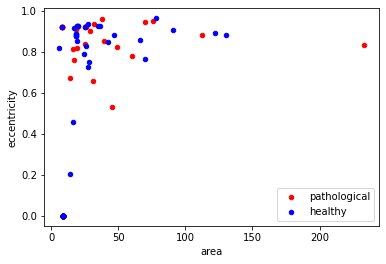

In [114]:
regionprops = pd.DataFrame(img)
regionprops2 = pd.DataFrame(img2)
ax1 = regionprops.plot(kind='scatter', x = 'area', y = 'eccentricity', color = 'r', label = 'pathological')
ax2 = regionprops2.plot(kind='scatter', x = 'area', y = 'eccentricity', color = 'b', label = 'healthy', ax = ax1)


In [44]:
#make gradcam heatmap for every image and normalise
heatmaps = np.zeros_like(imgs)
model = tf.keras.models.load_model("models/model20/")

for img in range(N):
    heatmaps[:,:,img] = GradCam(imgs[:,:,img], model, -5, 0)
    heatmaps[:,:,img] /= heatmaps[:,:,img].sum()


In [183]:
#get segmentation for every image
region_imgs = np.zeros_like(imgs, dtype=np.int64)

for img in range(N):
    region_imgs[:,:,img] = measure.label(imgs[:,:,img])

In [205]:
#find number of blobs in all images
num_blobs_array = []
for img in range(N):
    num_blobs_array.append(np.unique(region_imgs[:,:,0]).shape[0] - 1)

num_blobs = sum(num_blobs_array)
np.where(np.asarray(num_blobs_array).cumsum() > 18585)[0][0]

371

In [185]:
#generate interpretability scores for each blob; score is the sum of intensities of heatmap in the region
scores = np.zeros(num_blobs)
i = 0
for img in range(N):
    for region in np.unique(region_imgs[:,:,img]):
        if region != 0:
            x = np.copy(region_imgs[:,:,img])
            x[x != region] = 0
            scores[i] = (heatmaps[:,:,img] * x).sum()
            i += 1

In [212]:
blob_areas = np.zeros_like(scores)
u = 0
for img in range(N):
    areas = pd.DataFrame(measure.regionprops_table(region_imgs[:,:,img], properties=['area'])).to_numpy().squeeze()
    if 741.0 in areas:
        u = region_imgs[:,:,img]
    num_regions = np.unique(region_imgs[:,:,img]).shape[0] - 1
    blob_areas[np.where(blob_areas==0)[0][0]:np.where(blob_areas==0)[0][0]+num_regions] = areas



In [258]:
np.where(blob_areas == 0)

(array([172534, 172535, 172536, ..., 199997, 199998, 199999], dtype=int64),)

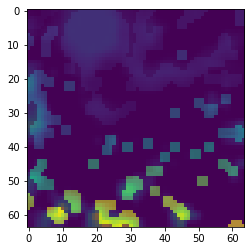

In [222]:
plt.imshow(u)
plt.imshow(GradCam(u, model, -5, 0), alpha = 0.4)


In [192]:
print(blob_areas.max())
print(np.where(blob_areas == blob_areas.sort()))


741.0
(array([18585], dtype=int64),)


In [255]:
np.mean(scores)

0.28724041297630437

In [252]:
import plotly
import plotly.express as px

df = pd.DataFrame(data=np.vstack((scores, blob_areas)).T, columns=['score', ' area'])
px.scatter(data_frame=df, x = df.columns[0], y = df.columns[1])


In [208]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(region_imgs[:,:,370])
ax[1].imshow(heatmaps[:,:,370])

pd.DataFrame(measure.regionprops_table(region_imgs[:,:,370], properties=['area']))


area
0     16
1     16
2    100
3      9
4     30
5     14
6      9
7     41
8     18
9     15
10    19
11     9
12    24
13    49
14   460
15     9
16    12
17     9
18    18
19     9
20    27
21    39
22     9
23    40
24    19
25    57
26     8
27     9
28   101
29     9
30     9
31    35
32     9
33    75
34    24
35    24
36    18
37     9
38    23
39     9
40     8